# Turkish Lira images classification using Tensorflow

# New Section

**Turkish lira currency classification using CNN**

**Subject:** Algorithms for Massive Datasets 

**Course:** Data Science and Economics (University of Milan)

**Prof:** Dario Malchiodi

**Context**

This dataset is collected to develop applications for visually impaired people.

**Content**

Turkish lira dataset is published on Kaggle and released under the GPL 2.0 license. The trained classifier must take an image as input and provide as output the corresponding predictions w.r.t. the 5, 10, 20, 500, 100, and 200 lira classes.

Each banknote category is divided into folders.
Each folder contains 1000 images. 925 for training, 75 for validation.
Some data augmentation techniques applied to images (increase brightness, decrease brightness, flip, add salt&pepper noise).
Image Shape: (1280, 720, 3)

In [1]:
#Importing Necessary Libraries:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.models import Sequential

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [2]:
#Upload your kaggle API json file:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pramodh941","key":"3af1e4df763d514df63dcbc9e6835bc4"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#Downloads the dataset using the Kaggle API:
!kaggle datasets download -d baltacifatih/turkish-lira-banknote-dataset

100% 3.49G/3.50G [01:04<00:00, 26.3MB/s]
100% 3.50G/3.50G [01:04<00:00, 57.8MB/s]


In [5]:
#Define the path and name of the directory to be created:
#This is the path where we will extract the dataset:
path = "/content/turkish-lira-banknote-dataset"

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Successfully created the directory /content/turkish-lira-banknote-dataset 


In [6]:
#Extracts the Images from the Zip file downloaded to the path we created above:
from zipfile import ZipFile
file_name = "turkish-lira-banknote-dataset.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall(path = "/content/turkish-lira-banknote-dataset/")
  print('Done')

Done


In [7]:
#Specifying the path of the folders containing Images:
DATASET_PATH = "/content/turkish-lira-banknote-dataset/"

In [8]:
files = sorted(glob.glob(os.path.join(DATASET_PATH, "**/*.png")))

In [9]:
img = cv2.imread(files[0])
height, width, channel = img.shape
    
print(f"Height: {height} Width: {width} Channel: {channel}")

Height: 720 Width: 1280 Channel: 3


In [10]:
# Plotting some images:
%matplotlib inline
def show_image(img_path):
    img = mpimg.imread(img_path)
    plt.figure()
    plt.imshow(img)

File path: /content/turkish-lira-banknote-dataset/10/10_1_0001.png
File path: /content/turkish-lira-banknote-dataset/100/100_1_0001.png
File path: /content/turkish-lira-banknote-dataset/20/20_1_0001.png
File path: /content/turkish-lira-banknote-dataset/200/200_1_0001.png
File path: /content/turkish-lira-banknote-dataset/5/5_1_0001.png
File path: /content/turkish-lira-banknote-dataset/50/50_1_0001.png


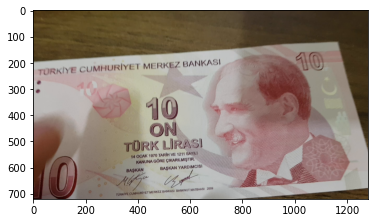

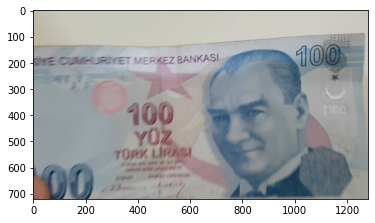

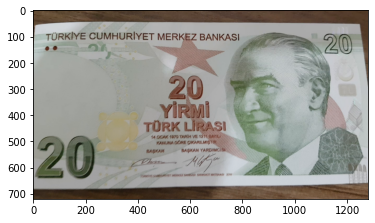

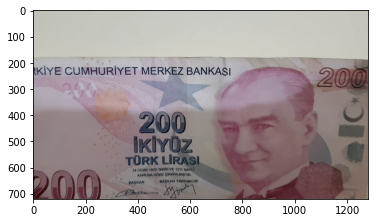

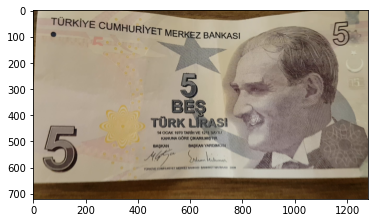

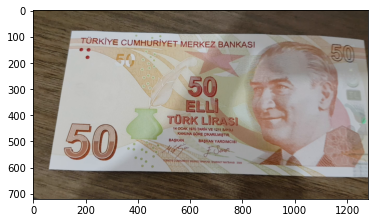

In [11]:
image_idxs = [0, 1000, 2000, 3000, 4000, 5000]

for image_idx in image_idxs:
    print(f"File path: {files[image_idx]}")
    show_image(files[image_idx])

Our job is to build a classifier that can predict the correct labels for these images. We use Convolutional Neural Networks which are the best at Image classification tasks.

To achieve distributed training, In tensorflow configure the `TF_CONFIG` file like

```json
os.environ['TF_CONFIG'] = json.dumps({
    'cluster': {
        'worker': ["localhost:20000", "localhost:20001"]
    },
    'task': {'type': 'worker', 'index': 0}
})
```

and replace "localhost:20000" and "localhost:20001" with the ip addresses of your workers. More info [here](https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras).


We use the `MultiWorkerMirroredStrategy` for syncronized training across multiple machines with multiple GPUs. See [here](https://www.tensorflow.org/api_docs/python/tf/distribute/experimental/MultiWorkerMirroredStrategy) and [here](https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras) for more details.

In [12]:
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CollectiveCommunication.AUTO


We resize each picture to 64x64 and set a batch size of 64 images per worker. In this example we are using a single worker, you need to change that in the `TF_CONFIG` file if you specify more than one worker.

In [13]:
IMG_WIDTH = 64
IMG_HEIGHT = 64

NUM_WORKERS = 1
PER_WORKER_BATCH_SIZE = 64
GLOBAL_BATCH_SIZE = PER_WORKER_BATCH_SIZE * NUM_WORKERS

**Scalability in reading data:** We won't load all images into main memory, but we use `tf.Data` API in order to read data in small batches. In order to do this, we won't use the train/test split, but we will randomly split the data: 80% for training and 20% for testing.

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  label_mode='categorical',
  batch_size=GLOBAL_BATCH_SIZE)

Found 6000 files belonging to 6 classes.
Using 4800 files for training.


In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  label_mode='categorical',
  batch_size=GLOBAL_BATCH_SIZE)

Found 6000 files belonging to 6 classes.
Using 1200 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['10', '100', '20', '200', '5', '50']


In [17]:
num_classes = len(class_names)

Converting the **RGB** Images to **Grayscale** (in the range [0,1]), which is more convenient for a neural network. This scaling will be done real-time while batch reading the images from disk.

In [18]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255

    return image, label

**Parallel Computing:** We implement **prefetch** and **caching** of portions of the dataset in order to improve performance as suggested [here](https://www.tensorflow.org/guide/data_performance)

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(scale, num_parallel_calls=AUTOTUNE).repeat().cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(scale, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

We now distribute the input across multiple devices. See [here](https://www.tensorflow.org/tutorials/distribute/input) for more details.

In [20]:
dist_dataset = strategy.experimental_distribute_dataset(train_ds)

Let's now experiment on some CNN architectures for training:

In [21]:
# Model 1: Using VGG blocks

with strategy.scope():
    modelVGG = Sequential()

    # VGG Blocks
    modelVGG.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))
    modelVGG.add(Activation('relu'))
    modelVGG.add(Conv2D(32, (3, 3)))
    modelVGG.add(Activation('relu'))
    modelVGG.add(MaxPooling2D(pool_size=(2, 2)))

    modelVGG.add(Conv2D(64, (3, 3), padding='same'))
    modelVGG.add(Activation('relu'))
    modelVGG.add(Conv2D(64, (3, 3)))
    modelVGG.add(Activation('relu'))
    modelVGG.add(MaxPooling2D(pool_size=(2, 2)))

    modelVGG.add(Conv2D(128, (3, 3), padding='same'))
    modelVGG.add(Activation('relu'))
    modelVGG.add(Conv2D(128, (3, 3)))
    modelVGG.add(Activation('relu'))
    modelVGG.add(MaxPooling2D(pool_size=(2, 2)))

    modelVGG.add(Flatten())

    # Dense layers
    modelVGG.add(Dense(128))
    modelVGG.add(Activation('relu'))
    modelVGG.add(Dropout(0.5))
    modelVGG.add(Dense(num_classes, activation='softmax'))

    modelVGG.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])

Early stopping to speed up training and reduce overfitting

In [22]:
es = EarlyStopping(monitor='loss', verbose=1, mode='min', patience = 2, min_delta=0.01)

Training the model:

In [23]:
historyVGG = modelVGG.fit(dist_dataset,
            epochs=15,
            steps_per_epoch = 75,
            callbacks=[es])

Epoch 1/15
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
75/75 [==============================] - 79s 1s/step - loss: 1.6059 - accuracy: 0.3002
Epoch 2/15
75/75 [==============================] - 83s 1s/step - loss: 0.9184 - accuracy: 0.6406
Epoch 3/15
75/75 [==============================] - 84s 1s/step - loss: 0.6856 - accuracy: 0.7400
Epoch 4/15
75/75 [==============================] - 85s 1s/step - loss: 0.5719 - accuracy: 0.7923
Epoch 5/15
75/75 [==============================] - 84s 1s/step - loss: 0.3445 - accuracy: 0.8683
Epoch 6/15
75/75 [==============================] - 87s 1s/step - loss: 0.2846 - accuracy: 0.9021
Epoch 7/15
75/75 [==============================] - 86s 1s/step - loss: 0.3142 - accuracy: 0.8979
Epoch 8/15
75/75 [==============================] - 87s 1s/step - loss: 0.2290 - accuracy: 0.9167
Epoch 9/15
75/75 [==============================] - 86s 1s/step - loss: 0.1519 - accuracy: 0.9490
Epoch 10/15
75/75 [=================

Let's evaluate it on the test set

In [24]:
modelVGG.evaluate(test_ds)

19/19 [==============================] - 14s 758ms/step - loss: 0.1122 - accuracy: 0.9625


[0.11219937354326248, 0.9624999761581421]

In [25]:
# Model 2: VGG with Batch Normalisation:

with strategy.scope():
    modelVGG_BatchNorm = Sequential()

    # VGG Blocks
    modelVGG_BatchNorm.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))
    modelVGG_BatchNorm.add( BatchNormalization( axis = 3 ) )
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(Conv2D(32, (3, 3)))
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(MaxPooling2D(pool_size=(2, 2)))

    modelVGG_BatchNorm.add(Conv2D(64, (3, 3), padding='same'))
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(Conv2D(64, (3, 3)))
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(MaxPooling2D(pool_size=(2, 2)))

    modelVGG_BatchNorm.add(Conv2D(128, (3, 3), padding='same'))
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(Conv2D(128, (3, 3)))
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(MaxPooling2D(pool_size=(2, 2)))

    modelVGG_BatchNorm.add(Flatten())

    # Dense layers
    modelVGG_BatchNorm.add(Dense(128))
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(Dropout(0.5))
    modelVGG_BatchNorm.add(Dense(num_classes, activation='softmax'))

    modelVGG_BatchNorm.compile(optimizer=tf.keras.optimizers.Adam(), 
                                  loss=tf.keras.losses.CategoricalCrossentropy(),
                                  metrics=["accuracy"])

In [26]:
historyVGG_BatchNorm = modelVGG_BatchNorm.fit(dist_dataset,
                                                epochs=15,
                                                steps_per_epoch = 75,
                                                callbacks=[es])

Epoch 1/15
75/75 [==============================] - 86s 1s/step - loss: 1.0777 - accuracy: 0.5548
Epoch 2/15
75/75 [==============================] - 86s 1s/step - loss: 0.4028 - accuracy: 0.8604
Epoch 3/15
75/75 [==============================] - 92s 1s/step - loss: 0.1817 - accuracy: 0.9410
Epoch 4/15
75/75 [==============================] - 91s 1s/step - loss: 0.1196 - accuracy: 0.9635
Epoch 5/15
75/75 [==============================] - 88s 1s/step - loss: 0.1113 - accuracy: 0.9642
Epoch 6/15
75/75 [==============================] - 95s 1s/step - loss: 0.0937 - accuracy: 0.9694
Epoch 7/15
75/75 [==============================] - 90s 1s/step - loss: 0.0548 - accuracy: 0.9829
Epoch 8/15
75/75 [==============================] - 87s 1s/step - loss: 0.0397 - accuracy: 0.9885
Epoch 9/15
75/75 [==============================] - 97s 1s/step - loss: 0.0671 - accuracy: 0.9804
Epoch 10/15
75/75 [==============================] - 93s 1s/step - loss: 0.0449 - accuracy: 0.9850
Epoch 00010: early 

In [28]:
modelVGG_BatchNorm.evaluate(test_ds)

19/19 [==============================] - 0s 9ms/step - loss: 0.3391 - accuracy: 0.9200


[0.33906692266464233, 0.9200000166893005]

In [29]:
# Using a simpler Network architecture:
with strategy.scope():
    model2 = Sequential()
    model2.add( ZeroPadding2D( input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), padding = ( 3, 3 ) ) )
    model2.add( Conv2D( 32, ( 7, 7 ), strides = (  1, 1 ) ) )
    model2.add( Activation( 'relu' ) )
    model2.add( MaxPooling2D( ( 2, 2 ) ) )
    model2.add( Flatten() )
    model2.add( Dense( 6 ) )
    model2.add(Dense(num_classes, activation='softmax'))
    
    model2.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])

In [30]:
history2 = model2.fit( dist_dataset, epochs = 20 , steps_per_epoch = 75, callbacks=[es])

Epoch 1/20
75/75 [==============================] - 85s 1s/step - loss: 1.4494 - accuracy: 0.4300
Epoch 2/20
75/75 [==============================] - 86s 1s/step - loss: 0.8169 - accuracy: 0.7023
Epoch 3/20
75/75 [==============================] - 85s 1s/step - loss: 0.5233 - accuracy: 0.8208
Epoch 4/20
75/75 [==============================] - 85s 1s/step - loss: 0.3732 - accuracy: 0.8842
Epoch 5/20
75/75 [==============================] - 84s 1s/step - loss: 0.2551 - accuracy: 0.9244
Epoch 6/20
75/75 [==============================] - 84s 1s/step - loss: 0.1810 - accuracy: 0.9540
Epoch 7/20
75/75 [==============================] - 84s 1s/step - loss: 0.1288 - accuracy: 0.9702
Epoch 8/20
75/75 [==============================] - 85s 1s/step - loss: 0.1007 - accuracy: 0.9762
Epoch 9/20
75/75 [==============================] - 86s 1s/step - loss: 0.0782 - accuracy: 0.9829
Epoch 10/20
75/75 [==============================] - 86s 1s/step - loss: 0.0591 - accuracy: 0.9877
Epoch 11/20
75/75 [

In [31]:
model2.evaluate(test_ds)

19/19 [==============================] - 0s 6ms/step - loss: 0.1077 - accuracy: 0.9683


[0.10765597224235535, 0.9683333039283752]

In [32]:
# Simple Network with Batch Normalisation:
with strategy.scope():
    model3 = Sequential()
    model3.add( ZeroPadding2D( input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), padding = ( 3, 3 ) ) )
    model3.add( Conv2D( 32, ( 7, 7 ), strides = (  1, 1 ) ) )
    model3.add( BatchNormalization( axis = 3 ) )
    model3.add( Activation( 'relu' ) )
    model3.add( MaxPooling2D( ( 2, 2 ) ) )
    model3.add( Flatten() )
    model3.add( Dense( 6 ) )
    model3.add(Dense(num_classes, activation='softmax'))
    
    model3.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])

In [33]:
history3 = model3.fit( dist_dataset, epochs = 20 , steps_per_epoch = 75, callbacks=[es])

Epoch 1/20
75/75 [==============================] - 85s 1s/step - loss: 2.6333 - accuracy: 0.5615
Epoch 2/20
75/75 [==============================] - 86s 1s/step - loss: 0.3950 - accuracy: 0.8746
Epoch 3/20
75/75 [==============================] - 86s 1s/step - loss: 0.2086 - accuracy: 0.9294
Epoch 4/20
75/75 [==============================] - 85s 1s/step - loss: 0.1334 - accuracy: 0.9571
Epoch 5/20
75/75 [==============================] - 86s 1s/step - loss: 0.1649 - accuracy: 0.9450
Epoch 6/20
75/75 [==============================] - 86s 1s/step - loss: 0.0894 - accuracy: 0.9681
Epoch 7/20
75/75 [==============================] - 86s 1s/step - loss: 0.0587 - accuracy: 0.9794
Epoch 8/20
75/75 [==============================] - 85s 1s/step - loss: 0.0200 - accuracy: 0.9942
Epoch 9/20
75/75 [==============================] - 87s 1s/step - loss: 0.0109 - accuracy: 0.9979
Epoch 10/20
75/75 [==============================] - 87s 1s/step - loss: 0.0074 - accuracy: 0.9992
Epoch 11/20
75/75 [

In [35]:
model3.evaluate(test_ds)

19/19 [==============================] - 0s 6ms/step - loss: 0.1086 - accuracy: 0.9733


[0.10856376588344574, 0.9733333587646484]

**On Test Set:**

Our VGG network acheived an accuracy of 96.25%

VGG with Batch Normalisation acheived an accuracy of 92.00%

Our Simple network acheived an accuracy of 96.83%

Simple network with Batch Normalisation acheived an accuracy of **97.33%**

While we used Adaptive gradients as optimizer in all the networks, Stochastic gradient descent takes longer training time.

We conclude that a Simpler network with Batch Normalisation trains faster (in 12 epochs) and also acheives the better accuracy for this dataset